In [417]:
using Rays
using GeoDataFrames
using GeoInterface: coordinates

## Load Ribasim model data

In [418]:
gpkg_path = normpath(@__DIR__, "generated_testmodels/basic/database.gpkg")
node_rows = GeoDataFrames.read(gpkg_path, "Node");
edge_rows = GeoDataFrames.read(gpkg_path, "Edge");

## Define Scene

In [419]:
scene = Rays.Scene()

# Define a camera
camera = Rays.Camera(; screen_res = [500, 1000], screen_size = [0.1, 0.2])
push!(scene, camera)

# Let the camera look towards the origin
from = Float32[3, -3, 1]
to = zeros(Float32, 3)
Rays.look_at!(camera, from, to)

## Add nodes

In [420]:
node_size = 0.1f0

shape_dict = Dict(
    "Basin" => Rays.Sphere(node_size),
    "FractionalFlow" => Rays.Tetrahedron(1.5f0*node_size),
    "LevelBoundary" => Rays.Sphere(node_size),
    "LinearResistance" => Rays.Tetrahedron(1.5f0*node_size),
    "ManningResistance" => Rays.Cube(node_size),
    "TabulatedRatingCurve" => Rays.Cube(node_size),
    # Pump: Hexagon
    # Outlet: Hexagon
    "Terminal" => Rays.Cube(node_size),
    # FlowBoundary: Hexagon
    # DiscreteControl: *
    # PidControl: x
    "User" => Rays.Cube(node_size)
)
shape_default = Rays.Sphere(node_size)

rotation_dict = Dict(
    "ManningResistance" => Rays.rotation(Float32[0, 0, 1], Float32(π/4)),
    "TabulatedRatingCurve" => Rays.rotation(Float32[0, 0, 1], Float32(π/4)),
    "FractionalFlow" => Rays.rotation(Float32[0, 0, 1], Float32(π/2)),
    "LinearResistance" => Rays.rotation(Float32[0, 0, 1], Float32(π/2)),
)
rotation_default = Rays.identity_transform(Float32)

texture_dict = Dict(
    "Basin" => Rays.UniformTexture(Float32[0, 0, 1]),
    "FractionalFlow" => Rays.UniformTexture(Float32[1, 0, 0]),
    "LevelBoundary" => Rays.UniformTexture(Float32[0, 1, 0]),
    "LinearResistance" => Rays.UniformTexture(Float32[0, 1, 0]),
    "ManningResistance" => Rays.UniformTexture(Float32[1, 0, 0]),
    "TabulatedRatingCurve" => Rays.UniformTexture(Float32[0, 1, 0]),
    "Pump" => Rays.UniformTexture(Float32[0.5, 0.5, 0.5]),
    "Outlet" => Rays.UniformTexture(Float32[0, 1, 0]),
    "Terminal" => Rays.UniformTexture(Float32[0.7, 0.0, 0.7]),
    "FlowBoundary" => Rays.UniformTexture(Float32[0.7, 0.0, 0.7]),
    "DiscreteControl" => Rays.UniformTexture(Float32[0.1, 0.1, 0.1]),
    "PidControl" => Rays.UniformTexture(Float32[0.1, 0.1, 0.1]),
    "User" => Rays.UniformTexture(Float32[0, 1, 0]),
)
texture_default = Rays.UniformTexture(Float32[1, 1, 1])

for row in eachrow(node_rows)
    node_shape = get(shape_dict, row.type, shape_default)
    translation = Rays.translation(Float32[coordinates(row.geom)..., 0.0])
    rotation = get(rotation_dict, row.type, rotation_default)
    transform = translation * rotation
    texture = get(texture_dict, row.type, texture_default)
    push!(scene, node_shape; transform, texture)
end

center = sum([transform.translation for transform in values(scene.transforms) if !ismissing(transform.translation)])/length(scene.transforms)
centering = Rays.translation(-center)

for (shape_name, transform) in scene.transforms
    Rays.set_transform!(scene, shape_name, centering * transform)
end

Rays.set_dropoff_curve_default!(scene, camera)

UndefVarError: UndefVarError: `set_default_dropoff_curve!` not defined

## Add edges

In [421]:
using LinearAlgebra: norm

r_edge = 0.02f0
rotation_z_to_x = Rays.rotation(Float32[0, 1, 0], Float32(π/2))

for row in eachrow(edge_rows)
    node_locs = coordinates(row.geom)
    diff = node_locs[2] - node_locs[1]
    edge_length::Float32 = norm(diff)
    edge_angle::Float32 = atan(diff[2], diff[1])
    rotation = Rays.rotation(Float32[0,0, 1], edge_angle) * rotation_z_to_x
    translation = Rays.translation(Float32[node_locs[1]..., 0.0] - center)
    transform = translation * rotation
    edge = Rays.RevolutionSurface(
        z -> r_edge,
        r_edge + 1f-2,
        0.0f0,
        edge_length,
    )
    push!(scene, edge; transform)
end

## View result

In [422]:
Rays.render!(scene)

In [423]:
using Images: colorview, RGB, N0f8

function view_canvas(camera)
    canvas_RGB = RGB{N0f8}.([view(camera.canvas, channel, :, :) for channel = 1:3]...)
    colorview(RGB, canvas_RGB)
end

view_canvas (generic function with 1 method)

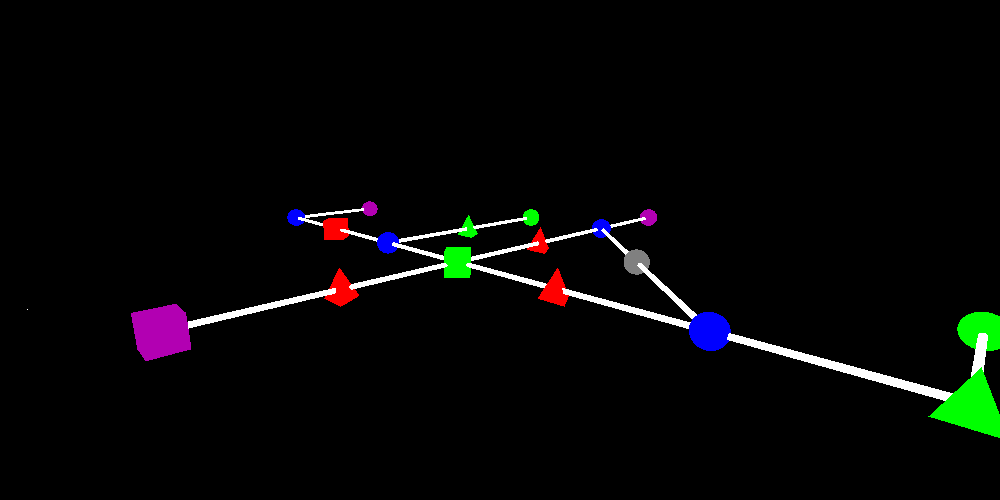

In [424]:
view_canvas(camera)